# Evaluation of network communications

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip

## About the Datasets
There are 2 datasets:
- **data3**: contains the data of the communication in one day without any anomalous behavior;
- **test3**: contains the data of the communication in one day with anomalous behavior;

Each dataframe contains the following columns:
- `index`: the index of the row
- `timestamp`: the timestamp of the event
- `src_ip`: the source IP address
- `dst_ip`: the destination IP address
- `proto`: the protocol used
- `port`: the port used
- `up_bytes`: the number of bytes uploaded by the source
- `down_bytes`: the number of bytes downloaded by the source

In [232]:
non_anomalous_df = pd.read_parquet('datasets/dataset3/data3.parquet')
non_anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
779943,957860,192.168.103.11,142.250.200.99,tcp,443,22243,228517
779944,957930,192.168.103.11,193.126.240.146,tcp,443,34885,199897
779945,958055,192.168.103.11,193.126.240.146,tcp,443,25383,216980
779946,958066,192.168.103.11,193.126.240.146,tcp,443,19162,99479
779947,958171,192.168.103.11,193.126.240.146,tcp,443,7247,60469


In [233]:
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')
anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
174163,1488996,192.168.103.17,192.168.103.228,udp,53,210,611
174164,1489002,192.168.103.17,192.168.103.228,udp,53,204,580
174165,1489088,192.168.103.17,142.250.200.99,tcp,443,8967,57243
174166,1489284,192.168.103.17,142.250.200.99,tcp,443,4501,34854
174167,1489314,192.168.103.17,142.250.200.99,tcp,443,22478,178992


## Inside the Network
In this section, we will analyze the traffic flow inside the network. We will look at who communicates with whom, the protocols used, and look for any anomalies in the communication.

#### Protocols used
##### Transport Layer Protocols
The packets are divided into two protocols: TCP and UDP. As we can see in the following plot, the number of TCP packets is higher than the number of UDP packets, with almost 90% of the packets being TCP packets.

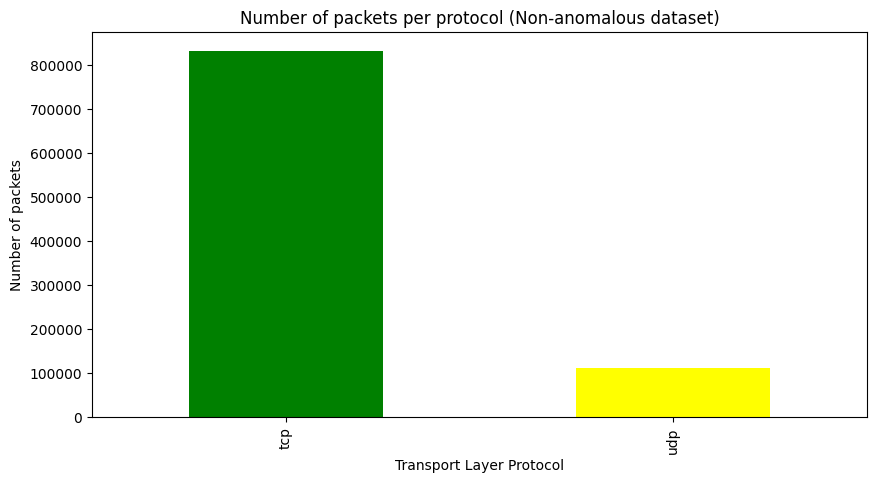

Ratio of TCP packets (Non-anomalous dataset): 0.8806493153897593
Ratio of UDP packets (Non-anomalous dataset): 0.11935068461024069


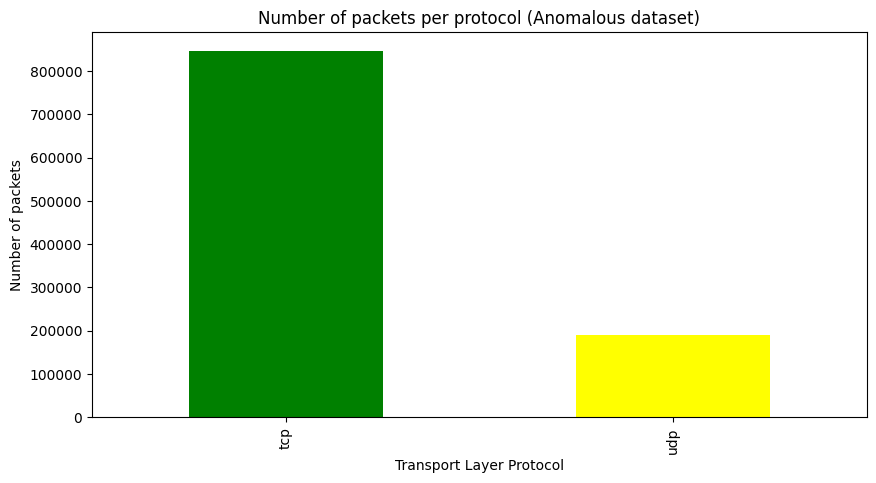

Ratio of TCP packets (Anomalous dataset): 0.816915101702591
Ratio of UDP packets (Anomalous dataset): 0.183084898297409


In [234]:
def transport_protocol_distribution(dataframe, title_prefix=''):
    plt.figure(figsize=(10, 5))
    dataframe['proto'].value_counts().plot(kind='bar', color=['green', 'yellow'])
    plt.title(f'Number of packets per protocol ({title_prefix} dataset)')
    plt.xlabel('Transport Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of TCP packets ({title_prefix} dataset):', len(dataframe[dataframe['proto'] == 'tcp']) / len(dataframe))
    print(f'Ratio of UDP packets ({title_prefix} dataset):', len(dataframe[dataframe['proto'] == 'udp']) / len(dataframe))

# Call the function for non-anomalous dataset
transport_protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
transport_protocol_distribution(anomalous_df, title_prefix='Anomalous')

##### Application Layer Protocols

The following plot shows the number of packets per application layer protocol. All the packets are divided into 2 protocols: HTTPS and DNS. The number of DNS packets is lower than the number of HTTPS packets, with almost 90% of the packets being HTTPS packets. 

However, the anomalous datasets show a small difference between the number of DNS and HTTPS packets, with a higher number of DNS packets (7% more than the non-anomalous dataset). This could indicate attacks like DNS flooding.

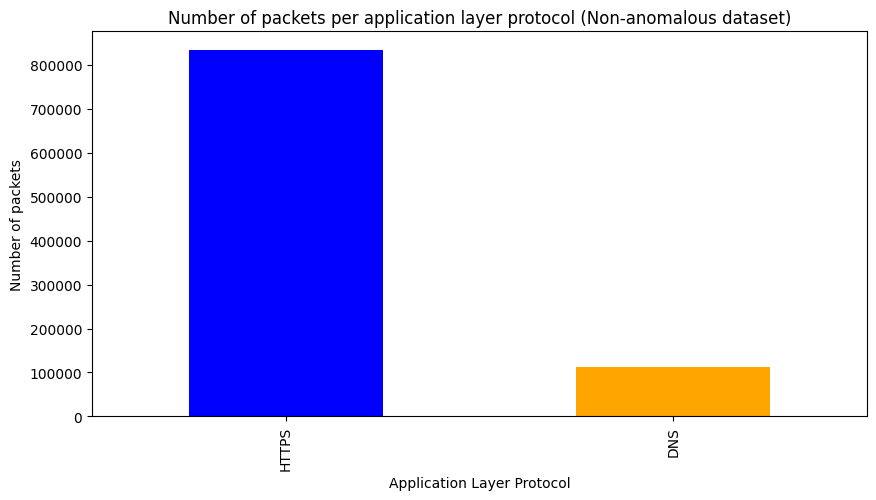

Ratio of HTTPS packets (Non-anomalous dataset): 0.8806493153897593
Ratio of DNS packets (Non-anomalous dataset): 0.11935068461024069


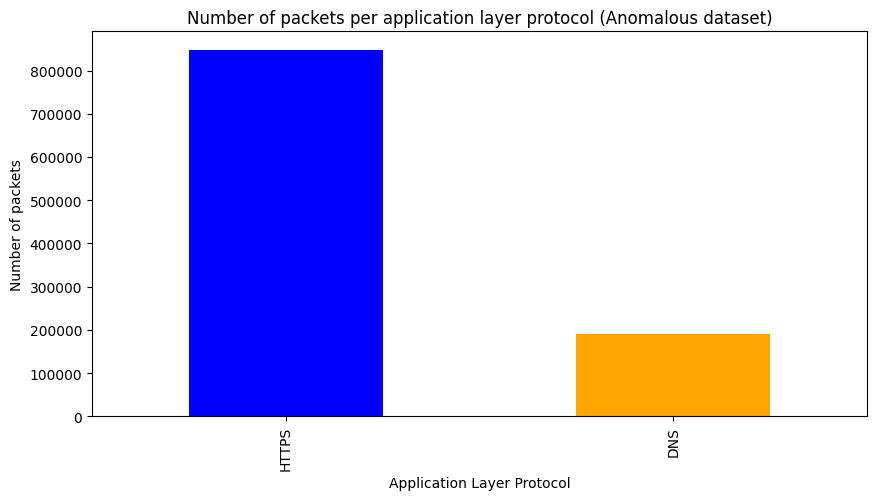

Ratio of HTTPS packets (Anomalous dataset): 0.816962315600821
Ratio of DNS packets (Anomalous dataset): 0.18303768439917906


In [235]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '22': 'SSH',
    '53': 'DNS',
    '21': 'FTP',
    '25': 'SMTP',
}

def protocol_distribution(dataframe, title_prefix=''):
    protocol_series = dataframe['port'].astype(str).map(application_protocols)

    if protocol_series.isnull().values.any():
        protocol_series = dataframe['port']

    plt.figure(figsize=(10, 5))
    protocol_series.value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.title(f'Number of packets per application layer protocol ({title_prefix} dataset)')
    plt.xlabel('Application Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of HTTPS packets ({title_prefix} dataset):', len(dataframe[dataframe['port'] == 443]) / len(dataframe))
    print(f'Ratio of DNS packets ({title_prefix} dataset):', len(dataframe[dataframe['port'] == 53]) / len(dataframe))

# Call the function for non-anomalous dataset
protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
protocol_distribution(anomalous_df, title_prefix='Anomalous')

### Packets sent (per Source IP)

The number of packets sent by the top 100 source IPs varies between the non-anomalous and anomalous datasets. 

As we can see, two machines have sent a higher number of packets in the **anomalous dataset**:
- **192.168.103.125**
- **192.168.103.90**

Pointing out that the machines could be compromised or used for malicious purposes.


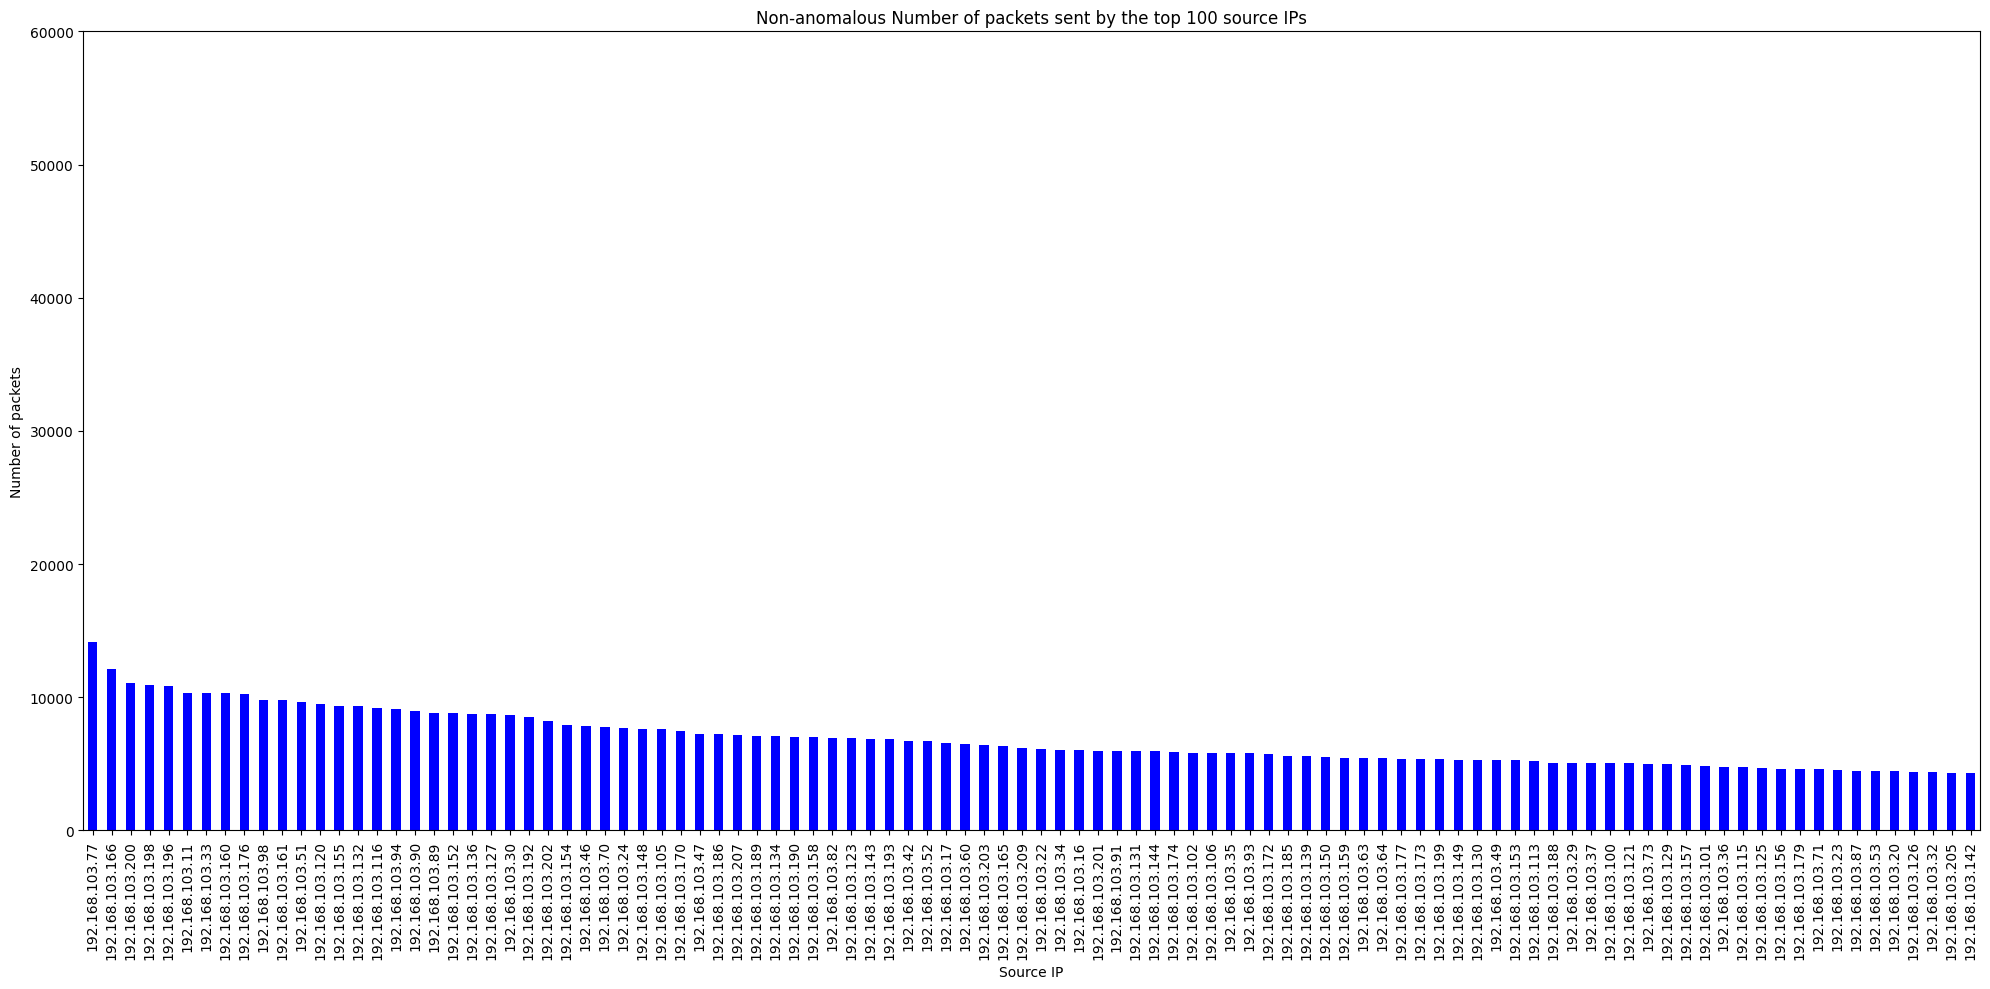

Top 10 source IPs (Non-anomalous dataset):

192.168.103.77 Packets sent: 14125 Percentage: 1.4921872771622982
192.168.103.166 Packets sent: 12120 Percentage: 1.28037591498811
192.168.103.200 Packets sent: 11045 Percentage: 1.1668112195580589
192.168.103.198 Packets sent: 10899 Percentage: 1.151387549295001
192.168.103.196 Packets sent: 10826 Percentage: 1.143675714163472
192.168.103.11 Packets sent: 10333 Percentage: 1.0915944166313647
192.168.103.33 Packets sent: 10333 Percentage: 1.0915944166313647
192.168.103.160 Packets sent: 10288 Percentage: 1.0868405456598742
192.168.103.176 Packets sent: 10265 Percentage: 1.0844107893855568
192.168.103.98 Packets sent: 9797 Percentage: 1.0349705312820556


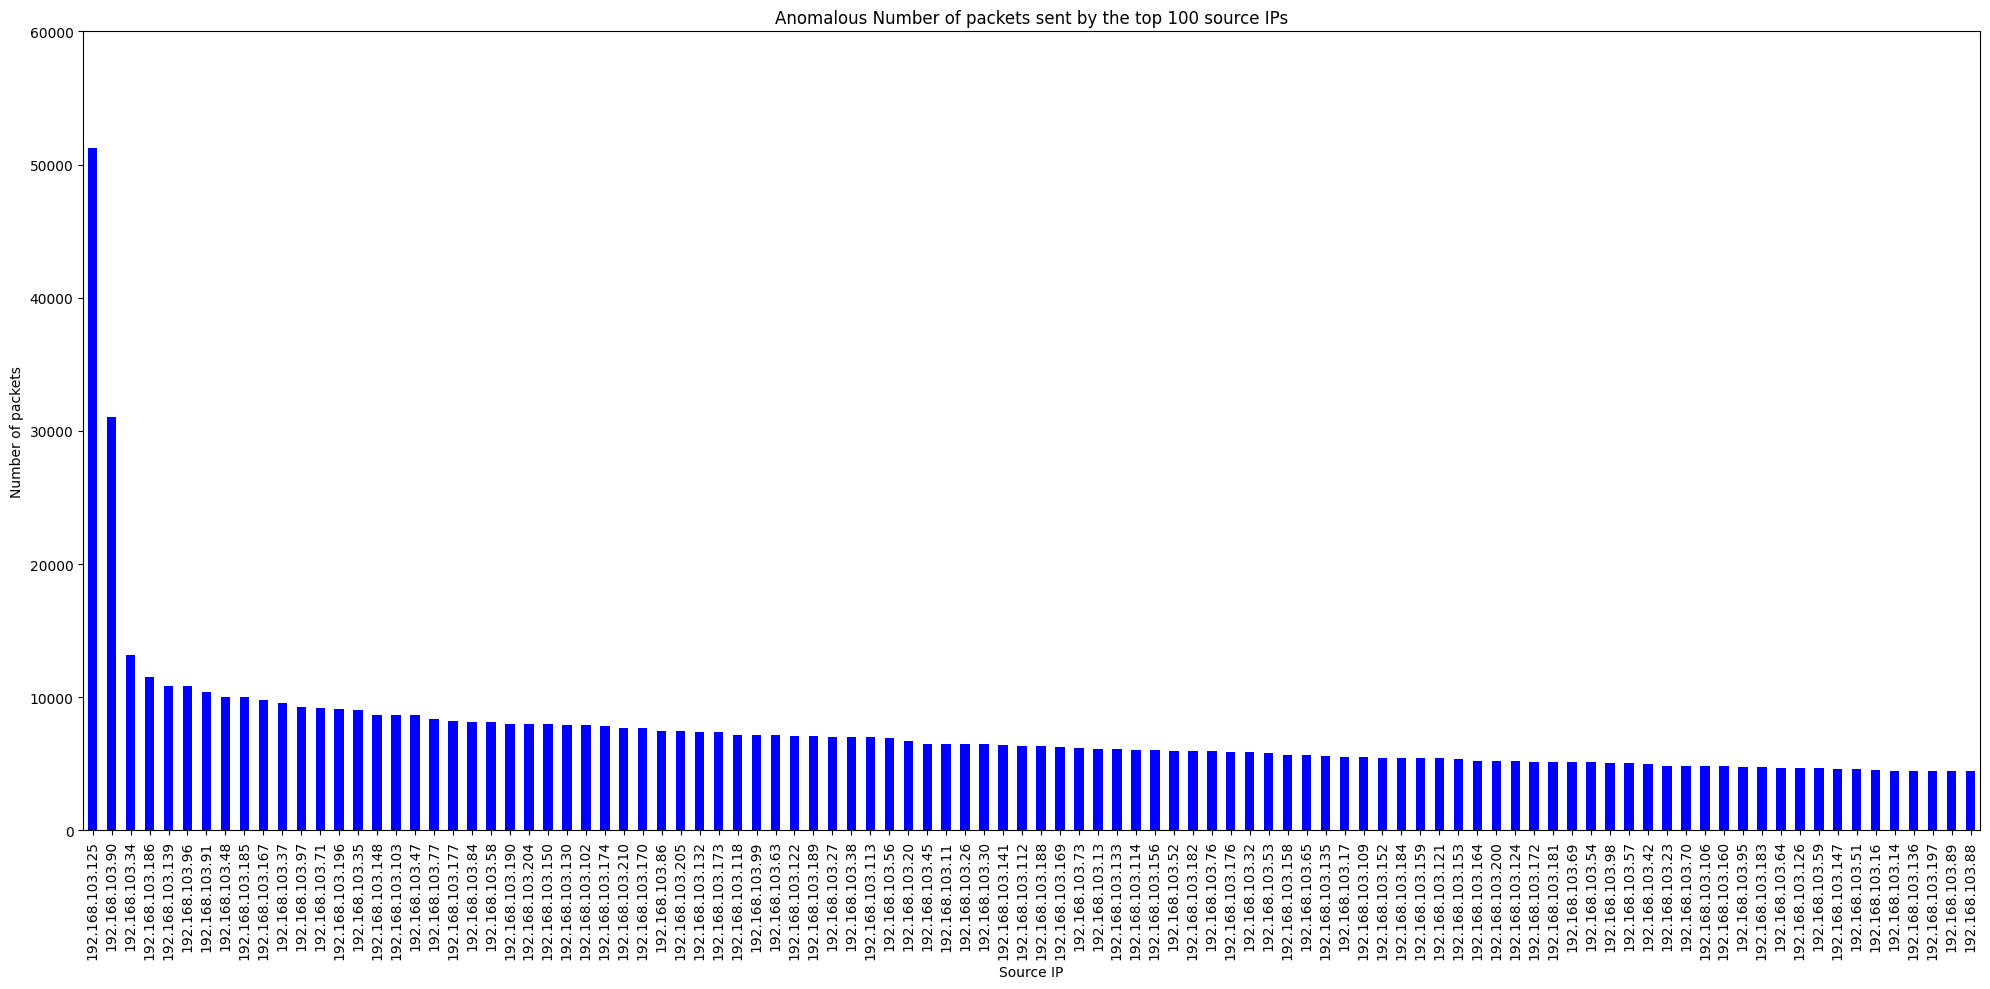

Top 10 source IPs (Anomalous dataset):

192.168.103.125 Packets sent: 51233 Percentage: 4.936550302072594
192.168.103.90 Packets sent: 31033 Percentage: 2.990181436266055
192.168.103.34 Packets sent: 13191 Percentage: 1.2710174113294086
192.168.103.186 Packets sent: 11535 Percentage: 1.111453706291011
192.168.103.139 Packets sent: 10884 Percentage: 1.0487266700712063
192.168.103.96 Packets sent: 10826 Percentage: 1.0431380861990887
192.168.103.91 Packets sent: 10385 Percentage: 1.000645577792124
192.168.103.48 Packets sent: 10030 Percentage: 0.9664395902989892
192.168.103.185 Packets sent: 10012 Percentage: 0.9647052022007458
192.168.103.167 Packets sent: 9794 Percentage: 0.9436998352331307


In [236]:
def top_source_ips(dataframe, frequency='1ms', top_n=100, y_lim=60000, title_prefix=''):
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
    dataframe.set_index('timestamp', inplace=True)

    grouped = dataframe.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

    src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
    top_src_ip_counts = src_ip_counts.head(top_n)

    plt.figure(figsize=(20, 10))
    top_src_ip_counts.plot(kind='bar', color='blue')
    plt.title(f'{title_prefix} Number of packets sent by the top {top_n} source IPs')
    plt.xlabel('Source IP')
    plt.ylabel('Number of packets')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Top 10 source IPs ({title_prefix} dataset):\n')
    for ip, count in top_src_ip_counts.head(10).items():
        print(ip, "Packets sent:", count, "Percentage:", count / len(dataframe) * 100)

# Call the function for non-anomalous dataset
top_source_ips(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
top_source_ips(anomalous_df, title_prefix='Anomalous')

#### Downloads/Uploads

The following plot shows the number of bytes uploaded and downloaded for both anomalous and non-anomalous datasets. This could be an indicator of a possible attack, as the number of bytes uploaded is higher than the number of bytes downloaded in the anomalous dataset.

In [ ]:
def dowload_upload_dns(dataframe, title_prefix=''):
    plt.figure(figsize=(10, 5))
    dataframe.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', color='blue', label='Uploads')
    dataframe.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', color='red', label='Downloads')
    plt.title(f'Number of bytes uploaded and downloaded per source IP ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of bytes')
    plt.legend()
    plt.show()

    print(f'Number of bytes uploaded ({title_prefix} dataset):', dataframe['up_bytes'].sum())
    print(f'Number of bytes downloaded ({title_prefix} dataset):', dataframe['down_bytes'].sum())
    
# Call the function for non-anomalous dataset
dowload_upload_dns(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
dowload_upload_dns(anomalous_df, title_prefix='Anomalous')


### Check for tunneling in the network (Tunneling)

### Traffic Sent by the possible compromised machines

After analyzing the number of packets sent by the top 100 source IPs, we will analyze the traffic sent by two the possible compromised machines that were identified in the previous analysis.

The following plot shows the number of packets sent by the machines, with the addresses **192.168.103.125** and **192.168.103.90**.